## Load libraries

In [1]:
library(plyr)
library(dplyr)
library(reshape)
library(reshape2)
library(ggplot2)
library(RColorBrewer)
library(ggrastr)
library(ggrepel)
library(data.table)
library(tidyverse)
library(repr)
options(ggrepel.max.overlaps = Inf)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘reshape’


The following object is masked from ‘package:dplyr’:

    rename


The following objects are masked from ‘package:plyr’:

    rename, round_any



Attaching package: ‘reshape2’


The following objects are masked from ‘package:reshape’:

    colsplit, melt, recast



Attaching package: ‘data.table’


The following objects are masked from ‘package:reshape2’:

    dcast, melt


The following object is masked from ‘package:reshape’:

    melt


The following objects are masked from ‘package:dplyr’:

    between, first, last


── Attaching packages ───────────────────────────────────────────────────────────────────────────────

## Set reference files

In [2]:
path_met_dams='../data/snATAC/Table_S6d_Met_DAMs.txt'

tab_1=fread('../data/snRNA/Average_expression_matrix.SCT.DataSlot.20230213.tsv',sep='\t')

meta=read.table('../data/snRNA/Cell_count_perGroup.forAverageExpressionMatrix.20230213.tsv',sep='\t',header=T)

scenic_path='../data/snRNA/Table_S6e_Met_regulons.txt'

cat=read_delim('../data/ATAC_catalog.20220114.v2.txt',delim='\t',show_col_types = FALSE)

Warning message in fread("../data/snRNA/Average_expression_matrix.SCT.DataSlot.20230213.tsv", :
“Detected 233 column names but the data has 234 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


In [3]:
#Read Met associated DAMs
tab_atac=read.table(path_met_dams,sep='\t',header=T)
tfs=unique(tab_atac$TF)


#Format expression table
tab_1=as.data.frame(tab_1)
rownames(tab_1)=tab_1[,1]
tab_1=tab_1[,-1]
tab_1=t(tab_1)
rownames(tab_1)=gsub('SCT\\.','',rownames(tab_1))
rownames(tab_1)=gsub('\\.','-',rownames(tab_1))
rownames(tab_1)=gsub('PDAC__Acinar-REG-','PDAC__Acinar-REG+',rownames(tab_1))

row_annot=as.data.frame(rownames(tab_1))
colnames(row_annot)='ID'
row_annot$Cell_type=gsub('(.*)__(.*)','\\2',row_annot$ID)
row_annot$Cell_type=gsub('(.*)_(.*)_(.*)','\\3',row_annot$ID)
row_annot$Cell_type=gsub('-',' ',row_annot$Cell_type)

In [4]:
#Filter cell groups with <20 cells
colnames(meta)=c('Cell_type','Cell_count')
meta$Cell_type=gsub(' ','-',meta$Cell_type)

meta_s=meta[meta$Cell_count>=20,]
row_annot=row_annot[row_annot$ID %in% meta_s$Cell_type & row_annot$Cell_type=='Tumor',]
row_annot$Disease=gsub('(.*)__(.*)','\\1',row_annot$ID)
row_annot$Disease=gsub('(.*)_(.*)_(.*)','\\1',row_annot$ID)
row_annot$Disease=gsub('(.*)__(.*)','\\1',row_annot$Disease)
row_annot$Piece_ID=gsub('(.*)__(.*)__Tumor','\\2',row_annot$ID)

In [5]:
cat=as.data.frame(cat)
colnames(cat)=gsub(' ','_',colnames(cat))

cat=cat %>% dplyr::select ('Piece_ID','Sample_Type')
colnames(cat)[2]=c('Sample_type')
row_annot=merge(row_annot,cat)
row_annot=row_annot[row_annot$Disease %in% c('PDAC','CRC','SKCM','UCEC'),]

#Keep only data for TFs across cancer cell groups from PDAC, CRC, SKCM and UCEC
tab=tab_1[row_annot$ID,colnames(tab_1) %in% tfs]

In [6]:
#Calculate Fold Change between Met and Primary tumor cells groups (using per sample expression levels)
all_st=NULL
for (can in c('PDAC','CRC','SKCM','UCEC')){
    row_annot_1=row_annot[row_annot$Disease==can,]
    tab_2=tab[row_annot_1$ID,]
    tab_2=reshape2::melt(as.matrix(tab_2))
    colnames(tab_2)=c('ID','TF','Expr')
    met_samples=row_annot_1$ID[row_annot_1$Sample_type=='Met']
    prim_samples=row_annot_1$ID[row_annot_1$Sample_type=='Tumor']
    for(tf in unique(tab_2$TF)){
        tab_3=tab_2[tab_2$TF==tf,]
        if (mean(tab_3$Expr[tab_3$ID %in% met_samples])>0 & mean(tab_3$Expr[tab_3$ID %in% prim_samples])>0){
        fch=mean(tab_3$Expr[tab_3$ID %in% met_samples])/mean(tab_3$Expr[tab_3$ID %in% prim_samples])
        st=cbind(log2(fch),tf,can)
        all_st=rbind(all_st,st)
        }
    }
}
all_st=as.data.frame(all_st)
colnames(all_st)=c('log2FCh','TF','Cancer')

In [7]:
tab_atac=read.table(path_met_dams,sep='\t',header=T)

scenic=read.table(scenic_path,sep='\t',header=T)
scenic$TF_Name=gsub('(.*)\\(\\+\\)','\\1',scenic$Regulon)

#Separately prioritize TFs across 4 cancers (the next four blocks of code)
all_tab=NULL

In [8]:
can='CRC'
scenic=read.table(scenic_path,sep='\t',header=T)
scenic$TF_Name=gsub('(.*)\\(\\+\\)','\\1',scenic$Regulon)
scenic=scenic[scenic$FDR<0.05 & scenic$Cancer==can,]

tab=tab_atac
tab=tab[tab$Cancer==can,]
 
sel_m_up=tab$TF[tab$TF %in% scenic$TF_Name[scenic$Score_diff>0] & tab$FDR <0.05 & tab$Score_diff>0]
sel_m_down=tab$TF[tab$TF %in% scenic$TF_Name[scenic$Score_diff<0] & tab$FDR <0.05 & tab$Score_diff<0]

#Assign minimum FDR for those FDR values that are below the R limit
all_fdrs=unique(tab$FDR)
all_fdrs=sort(all_fdrs)
tab$FDR=ifelse(tab$FDR==0,all_fdrs[2],tab$FDR)
tab$Direction=ifelse(tab$Score_diff>0, 'UP','DOWN')

#Add expression fold change (based on sample-level values)
degs_s=all_st
colnames(degs_s)=c('Fch_DEG','TF','Cancer')
tab=merge(tab,degs_s,all.x=T)
tab$Fch_DEG=as.numeric(as.character(unlist(tab$Fch_DEG)))
tab$Expr_score=ifelse(tab$Direction %in% c('DOWN') & tab$Fch_DEG<0, -tab$Fch_DEG,NA)
tab$Expr_score=ifelse(tab$Direction %in% c('UP') & tab$Fch_DEG>0, tab$Fch_DEG, tab$Expr_score)

#Prioritize the ones that are supported by SCENIC and also the ones with consistent RNA-seq expression fold change
tab_s=tab[(tab$TF %in% c(sel_m_up) & tab$Direction %in% c('UP') & tab$FDR<0.05 & !is.na(tab$Expr_score)) | 
          (tab$TF %in% c(sel_m_down) & tab$Direction %in% c('DOWN') & tab$FDR<0.05 & !is.na(tab$Expr_score)),]
tab$Label=ifelse(tab$TF %in% tab_s$TF,tab$TF,NA)
all_tab=rbind(all_tab,tab)


In [9]:
can='UCEC'
scenic=read.table(scenic_path,sep='\t',header=T)
scenic$TF_Name=gsub('(.*)\\(\\+\\)','\\1',scenic$Regulon)
scenic=scenic[scenic$FDR<0.05 & scenic$Cancer==can,]

tab=tab_atac
tab=tab[tab$Cancer==can,]
 
sel_m_up=tab$TF[tab$TF %in% scenic$TF_Name[scenic$Score_diff>0] & tab$FDR <0.05 & tab$Score_diff>0]
sel_m_down=tab$TF[tab$TF %in% scenic$TF_Name[scenic$Score_diff<0] & tab$FDR <0.05 & tab$Score_diff<0]

#Assign minimum FDR for those FDR values that are below the R limit
all_fdrs=unique(tab$FDR)
all_fdrs=sort(all_fdrs)
tab$FDR=ifelse(tab$FDR==0,all_fdrs[2],tab$FDR)
tab$Direction=ifelse(tab$Score_diff>0, 'UP','DOWN')

#Add expression fold change (based on sample-level values)
degs_s=all_st
colnames(degs_s)=c('Fch_DEG','TF','Cancer')
tab=merge(tab,degs_s,all.x=T)
tab$Fch_DEG=as.numeric(as.character(unlist(tab$Fch_DEG)))
tab$Expr_score=ifelse(tab$Direction %in% c('DOWN') & tab$Fch_DEG<0, -tab$Fch_DEG,NA)
tab$Expr_score=ifelse(tab$Direction %in% c('UP') & tab$Fch_DEG>0, tab$Fch_DEG, tab$Expr_score)

#Prioritize the ones that are supported by SCENIC and also the ones with consistent RNA-seq expression fold change
tab_s=tab[(tab$TF %in% c(sel_m_up) & tab$Direction %in% c('UP') & tab$FDR<0.05 & !is.na(tab$Expr_score)) | 
          (tab$TF %in% c(sel_m_down) & tab$Direction %in% c('DOWN') & tab$FDR<0.05 & !is.na(tab$Expr_score)),]
tab$Label=ifelse(tab$TF %in% tab_s$TF,tab$TF,NA)
all_tab=rbind(all_tab,tab)

In [10]:
can='PDAC'
scenic=read.table(scenic_path,sep='\t',header=T)
scenic$TF_Name=gsub('(.*)\\(\\+\\)','\\1',scenic$Regulon)
scenic=scenic[scenic$FDR<0.05 & scenic$Cancer==can,]

tab=tab_atac
tab=tab[tab$Cancer==can,]
 
sel_m_up=tab$TF[tab$TF %in% scenic$TF_Name[scenic$Score_diff>0] & tab$FDR <0.05 & tab$Score_diff>0]
sel_m_down=tab$TF[tab$TF %in% scenic$TF_Name[scenic$Score_diff<0] & tab$FDR <0.05 & tab$Score_diff<0]

#Assign minimum FDR for those FDR values that are below the R limit
all_fdrs=unique(tab$FDR)
all_fdrs=sort(all_fdrs)
tab$FDR=ifelse(tab$FDR==0,all_fdrs[2],tab$FDR)
tab$Direction=ifelse(tab$Score_diff>0, 'UP','DOWN')

#Add expression fold change (based on sample-level values)
degs_s=all_st
colnames(degs_s)=c('Fch_DEG','TF','Cancer')
tab=merge(tab,degs_s,all.x=T)
tab$Fch_DEG=as.numeric(as.character(unlist(tab$Fch_DEG)))
tab$Expr_score=ifelse(tab$Direction %in% c('DOWN') & tab$Fch_DEG<0, -tab$Fch_DEG,NA)
tab$Expr_score=ifelse(tab$Direction %in% c('UP') & tab$Fch_DEG>0, tab$Fch_DEG, tab$Expr_score)

#Prioritize the ones that are supported by SCENIC and also the ones with consistent RNA-seq expression fold change
tab_s=tab[(tab$TF %in% c(sel_m_up) & tab$Direction %in% c('UP') & tab$FDR<0.05 & !is.na(tab$Expr_score)) | 
          (tab$TF %in% c(sel_m_down) & tab$Direction %in% c('DOWN') & tab$FDR<0.05 & !is.na(tab$Expr_score)),]
tab$Label=ifelse(tab$TF %in% tab_s$TF,tab$TF,NA)
all_tab=rbind(all_tab,tab)

In [11]:
can='SKCM'
scenic=read.table(scenic_path,sep='\t',header=T)
scenic$TF_Name=gsub('(.*)\\(\\+\\)','\\1',scenic$Regulon)
scenic=scenic[scenic$FDR<0.05 & scenic$Cancer==can,]

tab=tab_atac
tab=tab[tab$Cancer==can,]
 
sel_m_up=tab$TF[tab$TF %in% scenic$TF_Name[scenic$Score_diff>0] & tab$FDR <0.05 & tab$Score_diff>0]
sel_m_down=tab$TF[tab$TF %in% scenic$TF_Name[scenic$Score_diff<0] & tab$FDR <0.05 & tab$Score_diff<0]

#Assign minimum FDR for those FDR values that are below the R limit
all_fdrs=unique(tab$FDR)
all_fdrs=sort(all_fdrs)
tab$FDR=ifelse(tab$FDR==0,all_fdrs[2],tab$FDR)
tab$Direction=ifelse(tab$Score_diff>0, 'UP','DOWN')

#Add expression fold change (based on sample-level values)
degs_s=all_st
colnames(degs_s)=c('Fch_DEG','TF','Cancer')
tab=merge(tab,degs_s,all.x=T)
tab$Fch_DEG=as.numeric(as.character(unlist(tab$Fch_DEG)))
tab$Expr_score=ifelse(tab$Direction %in% c('DOWN') & tab$Fch_DEG<0, -tab$Fch_DEG,NA)
tab$Expr_score=ifelse(tab$Direction %in% c('UP') & tab$Fch_DEG>0, tab$Fch_DEG, tab$Expr_score)

#Prioritize the ones that are supported by SCENIC and also the ones with consistent RNA-seq expression fold change
tab_s=tab[(tab$TF %in% c(sel_m_up) & tab$Direction %in% c('UP') & tab$FDR<0.05 & !is.na(tab$Expr_score)) | 
          (tab$TF %in% c(sel_m_down) & tab$Direction %in% c('DOWN') & tab$FDR<0.05 & !is.na(tab$Expr_score)),]
tab$Label=ifelse(tab$TF %in% tab_s$TF,tab$TF,NA)
all_tab=rbind(all_tab,tab)

## Do the plotting

In [12]:
tab=all_tab

#Cap expression score at 6
tab$Expr_score=ifelse(tab$Expr_score>=6,6, tab$Expr_score)
 
p <- ggplot(tab, aes(Score_diff, -log10(FDR))) + geom_point(alpha=0.4, colour="grey", data = tab) 


p <- p + geom_point(data=tab[!is.na(tab$Label) ,],aes(color=Direction,size=Expr_score), alpha=0.95)

p <- p + theme_minimal() +geom_hline(yintercept=-log10(0.05), alpha=0.5)+geom_vline(xintercept=0, alpha=0.5)

p <- p + ylab("-log10(FDR)") 

p <- p + xlab("snATAC-seq") 

#Highlight top by TF score difference and Expression score, and selected ones (GATA6 in PDAC, HNF4A in CRC, and FOXN3 in UCEC)
p <- p + geom_text_repel(data=tab[(!is.na(tab$Label) & tab$Expr_score>1 & abs(tab$Score_diff)>0.3) | 
                                  (tab$TF=='GATA6' & tab$Cancer=='PDAC') | 
                                  (tab$TF %in% c('HNF4A') & tab$Cancer=='CRC') | 
                                  (tab$TF %in% c('FOXN3') & tab$Cancer=='UCEC'),],
                         aes(y=-log10(FDR),x= Score_diff,label=TF),alpha=1,colour = "black",segment.size=0.1)

p <- p + facet_wrap(.~Cancer,scales = "free",nrow=1)

p <- p + theme(strip.text.x = element_text(size = 12),  strip.text.y = element_text(size = 14))

p <- p + theme(legend.position='right',legend.text=element_text(size=12),axis.title.x = element_text(size=12), 
               axis.title.y = element_text(size=12), axis.text.x = element_text(colour="black", size=12), 
               axis.text.y = element_text(colour="black", size=12),axis.ticks = element_blank(),
               panel.spacing.x = unit(0, "lines"), panel.spacing.y = unit(0, "lines"))

p <- p + scale_color_manual("Direction",values=c('UP'='red','DOWN'='blue'))


p <- p + scale_size_continuous(range  = c(0.1, 5), 
                         limits = c(min(tab$Expr_score,na.rm=T),max(tab$Expr_score,na.rm=T)), 
                         breaks = c(0.1, 2, 4, 6))

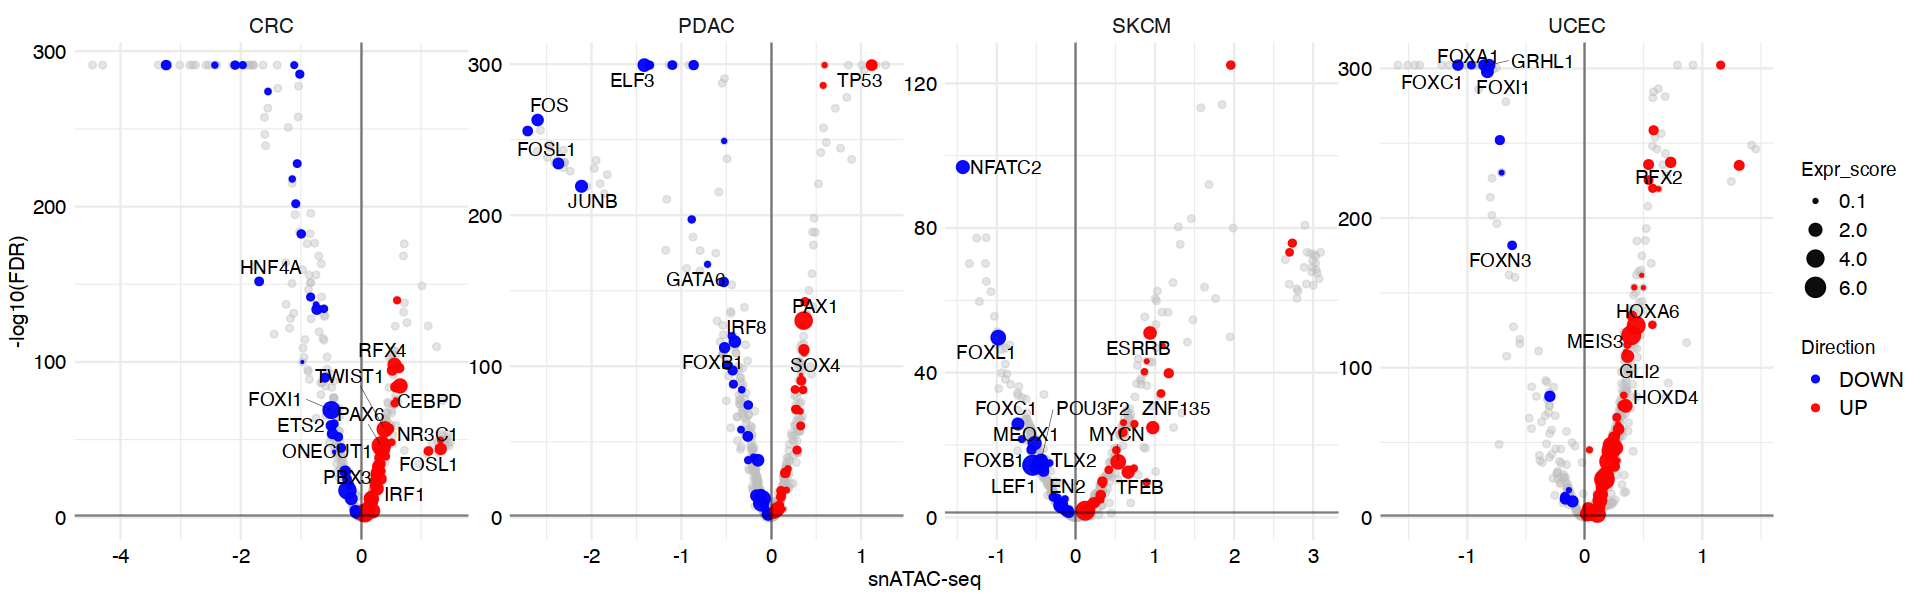

In [13]:
options(repr.plot.width=16, repr.plot.height=5)
p